__Short summary__

In this notebook:
- [graph attentions and visualizations](#graphs_viz);
- [constant features list](#constant_features).

Смысл ноутбука - посмотреть на константные признаки (создать список) + визуализация графов.

# Settings
___

In [ ]:
tables_dir = './tables/'
subset =  "in_domain_train" 
model =   "nt"
features_values = pd.read_csv(f'{tables_dir}all_features_{subset}_{model}.csv')

In [60]:
import pandas as pd
from collections import Counter
import numpy as np
from transformers import BertForSequenceClassification, BertTokenizer
import numpy as np
import os
import re
import torch
import networkx as nx    
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Извлечение матрицы внимания - функции для классификации bert
# copy form grab_weights.py
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# returnes tokenized sentence and attention matrices
def sentence_by_bert(model, tokenizer, MAX_LEN, sentence):
    inputs = tokenizer.encode_plus(text_preprocessing(sentence),
                                       None,
                                       return_tensors='pt',
                                       add_special_tokens=True,
                                       max_length=MAX_LEN,             # Max length to truncate/pad
                                       pad_to_max_length=True,         # Pad sentence to max length)
                                       truncation=True,
                                       return_length=True, 
                                       return_token_type_ids=True
                                      )

    mask = inputs['attention_mask'].detach().numpy()[0]
    token_ids = inputs['input_ids'].detach().numpy()[0]
    tokenized = tokenizer.convert_ids_to_tokens(token_ids)
    masked_tokenized = [t for t, a in zip (tokenized, mask) if a == 1 ]
    
    
    output = model(inputs['input_ids'])
    attentions = output['attentions']

    # token_type_ids -- zeroes
    # token_type_ids = inputs['token_type_ids'].detach().numpy()[0]
    # print('token_type_ids:', token_type_ids)

    num_layers = len(attentions)
    if not num_layers:
        return []
    num_heads = attentions[0].shape[1]
    result = np.asarray([[attentions[l][0,h].detach().numpy() for h in range(num_heads)] for l in range(num_layers)])
    result = result[:, :, :, mask==1]
    result = result[:, :, mask==1, :]
    return masked_tokenized, result

In [ ]:
def draw_heatmap(matrix, tokens, precision=2):
    plt.figure(figsize=(10,10))
    df = pd.DataFrame(matrix,columns=tokens,index=tokens)
    sns.heatmap(df,cmap="Reds",square=True, annot=True, fmt=f'.{precision}f')
def draw_graph(G, labels, pos = None):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_axis_off()
    plt.rcParams['font.family'] = 'sans-serif'
    if not pos: pos = nx.kamada_kawai_layout(G);
    nx.draw_networkx_nodes(G,pos, ax =ax,node_size=300, cmap=plt.cm.RdPu, node_color='pink', edgecolors='indigo', linewidths=0.5) 
    nx.draw_networkx_labels(G, pos,labels=labels, ax =ax, font_color='#36013f',font_size = 14)
    nx.draw_networkx_edges(G, pos=pos, ax =ax,  edge_color='indigo', alpha=0.3)
    return
def n_weak_components(matrix, threshold, tokens, draw = True):
    filtered_matrix = filtered(matrix, threshold)
    G = nx.from_numpy_matrix(np.array(filtered_matrix), \
                                                   create_using=nx.MultiDiGraph())
    if draw:
        draw_graph(G, labels = {i:l for i,l in enumerate(tokens)})
        draw_heatmap(matrix, tokens)
    
    return count_stat(G, function=nx.weakly_connected_components)

def count_simple_cycles(matrix, threshold, tokens, draw = True, cap=500):
    filtered_matrix = filtered(matrix, threshold)
    G = nx.from_numpy_matrix(np.array(filtered_matrix), \
                                                   create_using=nx.MultiDiGraph())
    if draw:
        draw_graph(G, labels = {i:l for i,l in enumerate(tokens)},pos = nx.circular_layout(G))
        draw_heatmap(matrix, tokens)
    return count_stat(G, function=nx.simple_cycles, cap=cap)

In [ ]:
def filtered(matrix, threshold):
    return np.where(matrix >= threshold, 1, 0).astype(np.int8)

def calculate_v(matrix, threshold):
    # get filtered symmetrized matrix. To move to separate function
    filtered_matrix = filtered(matrix, threshold)
    for idx in range(matrix.shape[0]):
        filtered_matrix[idx, idx] = 0
    filtered_matrix = np.maximum(filtered_matrix, filtered_matrix.transpose())
    
    # calculate vertice degree
    return np.sum(filtered_matrix) / matrix.shape[0]  

def count_stat(g_listt_j, function=nx.weakly_connected_components, cap=500):
    stat_amount = 0
    for _ in function(g_listt_j):
        stat_amount += 1
        if stat_amount >= cap:
            break
    return stat_amount

# Константные признаки
<a id='constant_features'></a>

In [12]:
irrelevant_dict = {i:features_values.loc[:,i].values[0] for i in features_values.columns if
                   np.unique(features_values.loc[:,i].values).shape[0] == 1}
relevant = {i:features_values.loc[:,i].values[0] for i in features_values.columns if not
                   np.unique(features_values.loc[:,i].values).shape[0] == 1}

In [11]:
features_names = {**{
    's': 'Connected strong components',
    'w': 'Connected weak components',
    'e': 'Edge number',
    'v': 'Avg. vertix degree',
    'c': 'Simple cycles',
    'b0': 'Betty 0',
    'b1': 'Betty 1'
}, **{
    'h0_s': 'h0, sum of lengths', 
    'h0_e': 'h0, entropy',
    'h0_t_d': 'h0, death time', 
    'h0_n_d_m': '#h0, death time',
    'h0_n_d_m':'#h0, death time',
    'h0_n_d_l':'#h0, death time',
    'h1_t_b':'h1, birth time',
    'h1_n_b_m':'#h1, birth time',
    'h1_n_b_l':'#h1, birth time', 
    'h1_n_b_l':'#h1, birth time',  
    'h1_s':'h1, sum of lengths',
    'h1_e':'h1, entropy',
    'h1_v':'h1, variance of lengths',
    'h1_nb':'number of barcodes in h1' }}

features_names

{'s': 'Connected strong components',
 'w': 'Connected weak components',
 'e': 'Edge number',
 'v': 'Avg. vertix degree',
 'c': 'Simple cycles',
 'b0': 'Betty 0',
 'b1': 'Betty 1',
 'h0_s': 'h0, sum of lengths',
 'h0_e': 'h0, entropy',
 'h0_t_d': 'h0, death time',
 'h0_n_d_m': '#h0, death time',
 'h0_n_d_l': '#h0, death time',
 'h1_t_b': 'h1, birth time',
 'h1_n_b_m': '#h1, birth time',
 'h1_n_b_l': '#h1, birth time',
 'h1_s': 'h1, sum of lengths',
 'h1_e': 'h1, entropy',
 'h1_v': 'h1, variance of lengths',
 'h1_nb': 'number of barcodes in h1'}

In [25]:
values_irr = []
features_irr = []
heads_irr = []
values_check = dict()
irrelevant_features = pd.DataFrame(columns = ['feature', 'description', 'head', 'most_frequent_value', '#null_heads/12'])
for item in irrelevant_dict.items():
    key = '_'.join(item[0].split('_')[:-2] + [item[0].split('_')[-1]]) # feature_layer
    if not values_check.get(key):
        values_check[key] =[item[1]]
    else:
        values_check[key].append(item[1])
already_added = set()
for key, value in values_check.items():
    most_frequent_value = Counter(value).most_common(1)[0][0]
    if np.unique(value).shape[0] !=1:
        most_frequent_value = Counter(value).most_common(1)[0][0]
    thr_ind = key.find('t0')
    thr = key.split('_')[-2]
    description = features_names[key[:thr_ind-1]] + f', threshold {thr}'
    feature_name = '_'.join(key.split('_')[:-1])
    head = key.split('_')[-1]
    same_as_w = 'w_' + '_'.join(key.split('_')[1:])
    if same_as_w not in already_added:
        irrelevant_features= irrelevant_features.append({'feature':feature_name, 'head':head, 
                                                    'most_frequent_value':most_frequent_value, 
                                                    'description':description, "#null_heads/12": len(value)},ignore_index=True)
        already_added.add(key)

irrelevant_features = irrelevant_features.sort_values(by = '#null_heads/12',ascending=False, ignore_index=True)

In [71]:
irrelevant_features.to_csv(f'{tables_dir}constant_features.csv')
irrelevant_features

,feature,description,head,most_frequent_value,#null_heads/12
0,w_t0.025,"Connected weak components, threshold t0.025",7,1.0,12
1,w_t0.025,"Connected weak components, threshold t0.025",2,1.0,12
2,w_t0.05,"Connected weak components, threshold t0.05",2,1.0,12
3,w_t0.025,"Connected weak components, threshold t0.025",5,1.0,12
4,w_t0.025,"Connected weak components, threshold t0.025",11,1.0,12
...,...,...,...,...,...
84,c_t0.5,"Simple cycles, threshold t0.5",3,1.0,1
85,w_t0.5,"Connected weak components, threshold t0.5",9,1.0,1
86,w_t0.75,"Connected weak components, threshold t0.75",9,1.0,1
87,v_t0.75,"Avg. vertix degree, threshold t0.75",0,0.0,1


In [28]:
irrelevant_features['feature'].values

array(['w_t0.025', 'w_t0.025', 'w_t0.05', 'w_t0.025', 'w_t0.025',
       'w_t0.025', 'w_t0.025', 'w_t0.05', 'w_t0.025', 'w_t0.05',
       'w_t0.025', 'w_t0.025', 'w_t0.05', 'w_t0.05', 'w_t0.025',
       'w_t0.025', 'w_t0.05', 'w_t0.05', 'w_t0.025', 'w_t0.05', 'w_t0.05',
       'w_t0.05', 'w_t0.05', 'w_t0.05', 'w_t0.1', 'b1_t0.75', 'w_t0.1',
       'c_t0.75', 'c_t0.75', 'b1_t0.75', 'b1_t0.75', 'w_t0.1', 'w_t0.1',
       'c_t0.75', 'b1_t0.75', 'c_t0.75', 'b1_t0.75', 'b1_t0.75', 'w_t0.1',
       'w_t0.1', 'w_t0.1', 'b1_t0.75', 'c_t0.75', 'b1_t0.75', 'w_t0.1',
       'b1_t0.75', 'c_t0.75', 'c_t0.75', 'c_t0.75', 'w_t0.1', 'b1_t0.75',
       'c_t0.75', 'w_t0.1', 'b1_t0.75', 'c_t0.5', 'w_t0.1',
       'h1_n_b_l_t0.70', 'b1_t0.75', 'b1_t0.5', 'h1_n_b_l_t0.70',
       'c_t0.75', 'b1_t0.5', 'c_t0.5', 'b1_t0.5', 'c_t0.75', 'c_t0.75',
       'b1_t0.5', 'c_t0.5', 'b1_t0.5', 'h0_n_d_l_t0.25', 'h0_n_d_m_t0.5',
       'h0_n_d_m_t0.75', 'h0_n_d_m_t0.5', 'h0_n_d_m_t0.75', 'b1_t0.5',
       'h0_n_d_l_t0.

# Визуализация графов

<a id='graphs_viz'></a>

На примере константного признака:

w_t0.025	Connected weak components, threshold t0.025	7	1.0	12

In [73]:
df = pd.read_csv("./data/cola_public/raw/" + subset + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
y = df['label'].values
X = features_values
trained_sentences = df['sentence'].values
trained_sentences

array(["Our friends won't buy this analysis, let alone the next one we propose.",
       "One more pseudo generalization and I'm giving up.",
       "One more pseudo generalization or I'm giving up.", ...,
       'It is easy to slay the Gorgon.',
       'I had the strangest feeling that I knew you.',
       'What all did you get for Christmas?'], dtype=object)

In [74]:
MAX_LEN = 64
input_dir = os.getcwd()
model_path = f'./BERT_uncased_nt_64'
model = BertForSequenceClassification.from_pretrained( model_path, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=True)

In [75]:
# sentence choice
index_chosen = 0
sentence = df['sentence'].values[index_chosen]
y_index = df['label'].values[index_chosen]
sentence,y_index

("Our friends won't buy this analysis, let alone the next one we propose.", 1)

In [76]:
tokenized, attentions = sentence_by_bert(model, tokenizer, MAX_LEN, sentence)
print(tokenized)
print(len(tokenized))
print(attentions.shape)

C:\Users\Irina\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2137: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']
19
(12, 12, 19, 19)


Our friends won't buy this analysis, let alone the next one we propose. 1
1


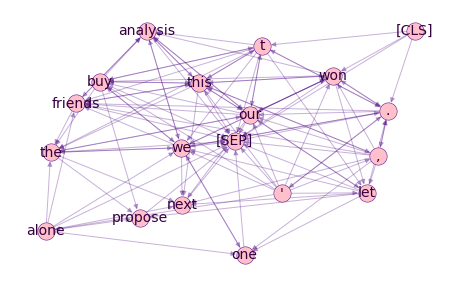

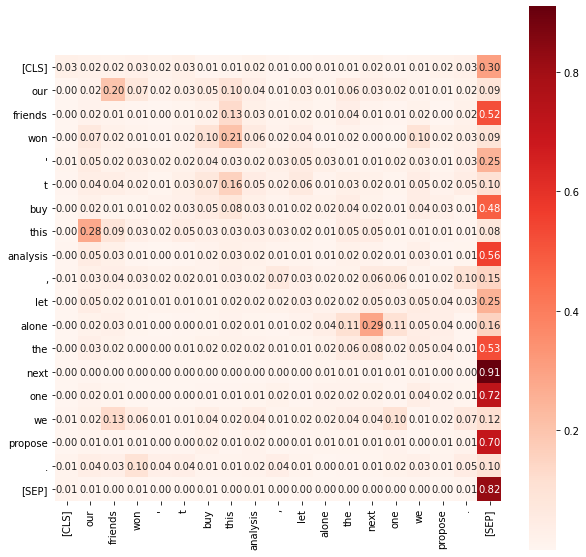

In [66]:
matrix = attentions[8, 7, :, :]
print(sentence, y_index)
print(n_weak_components(matrix, 0.025,tokenized))

Для того же предложения но с threshold = 0.75 (не входит в перечень константных)

Our friends won't buy this analysis, let alone the next one we propose. 1
18


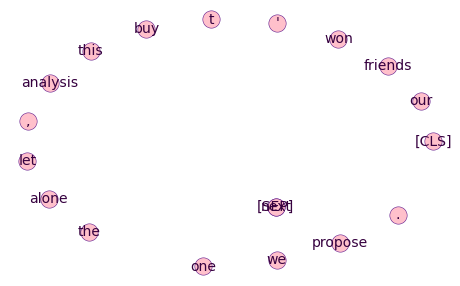

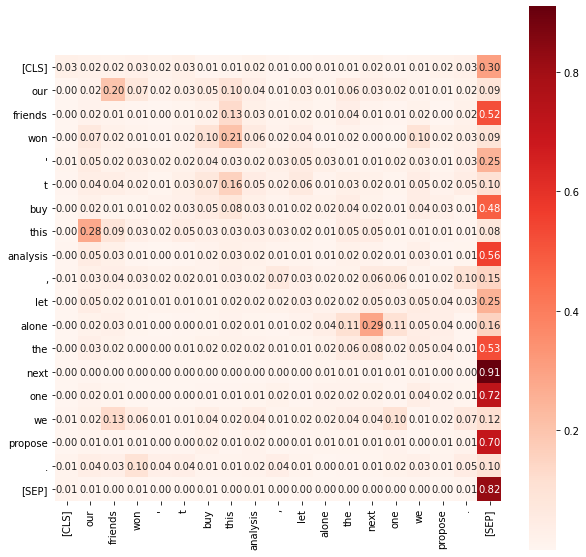

In [77]:
matrix = attentions[8, 7, :, :]
print(sentence, y_index)
print(n_weak_components(matrix, 0.75,tokenized))

Our friends won't buy this analysis, let alone the next one we propose.
1


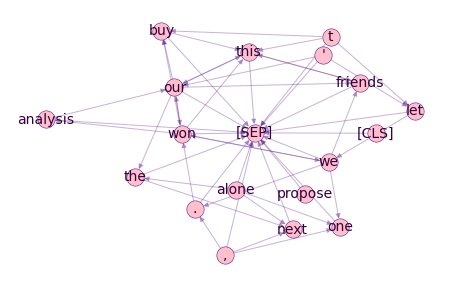

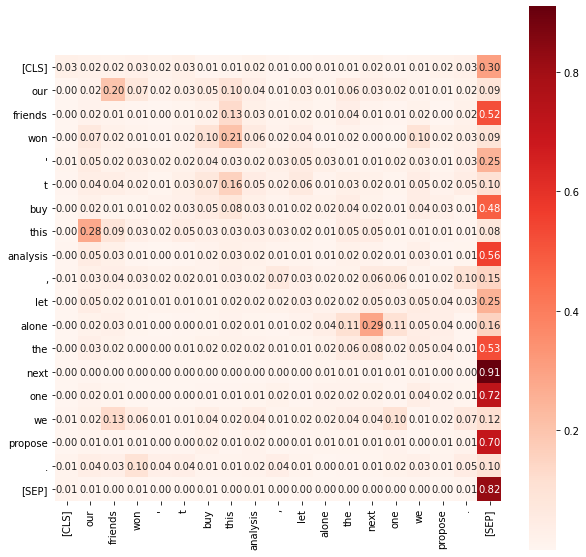

In [78]:
print(sentence)
print(n_weak_components(matrix, 0.05,tokenized))

One more pseudo generalization and I'm giving up.
1


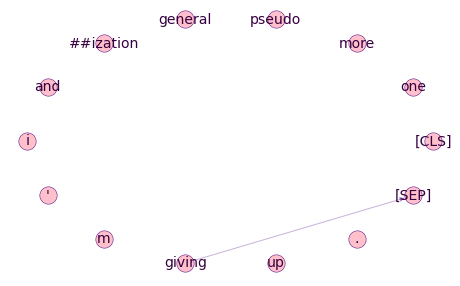

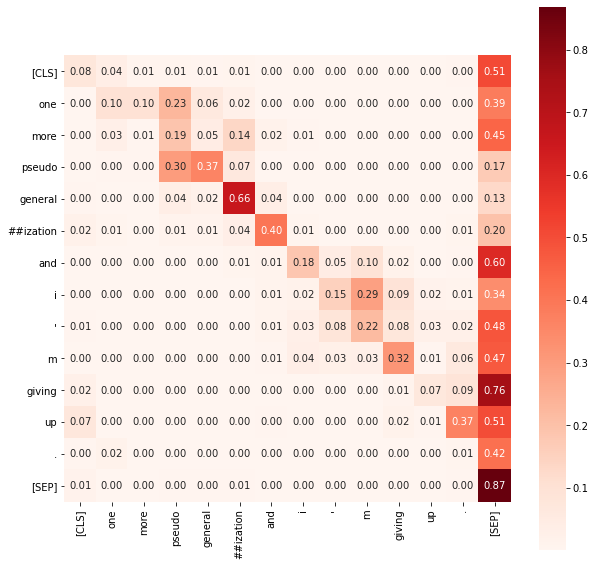

In [80]:
sentence = df['sentence'].values[1]
tokenized, attentions = sentence_by_bert(model, tokenizer, MAX_LEN, sentence)
matrix = attentions[6, 6, :, :]
print(sentence)
print(count_simple_cycles(matrix, 0.75, tokenized))